# 波动率分析

In [2]:
import os
import datetime as dt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("bmh")

读取数据

In [3]:
def read_binance_annual_ohlcv(year: int) -> pd.DataFrame:
    filepath = os.path.join("../data", f"binance_daily_ohlcv_{year}.csv")
    return pd.read_csv(filepath, index_col="timestamp", parse_dates=True)


years = [2022, 2023, 2024]
ohlcv = pd.concat((read_binance_annual_ohlcv(year) for year in years))

ohlcv

,open,high,low,close,volume,symbol
timestamp,,,,,,
2022-01-01,46216.9300,47954.6300,46208.3700,47722.6500,1.960446e+04,BTC/USDT
2022-01-02,47722.6600,47990.0000,46654.0000,47286.1800,1.834046e+04,BTC/USDT
2022-01-03,47286.1800,47570.0000,45696.0000,46446.1000,2.766208e+04,BTC/USDT
2022-01-04,46446.1000,47557.5400,45500.0000,45832.0100,3.549141e+04,BTC/USDT
2022-01-05,45832.0100,47070.0000,42500.0000,43451.1300,5.178412e+04,BTC/USDT
...,...,...,...,...,...,...
2024-04-05,0.2961,0.2989,0.2780,0.2936,9.776790e+06,BAT/USDT
2024-04-06,0.2936,0.2991,0.2918,0.2964,3.313721e+06,BAT/USDT
2024-04-07,0.2963,0.3030,0.2954,0.3023,5.018225e+06,BAT/USDT


计算历史标准差

- 选择货币对和样本
- 根据价格或者收益率来计算波动率
- 画波动率图

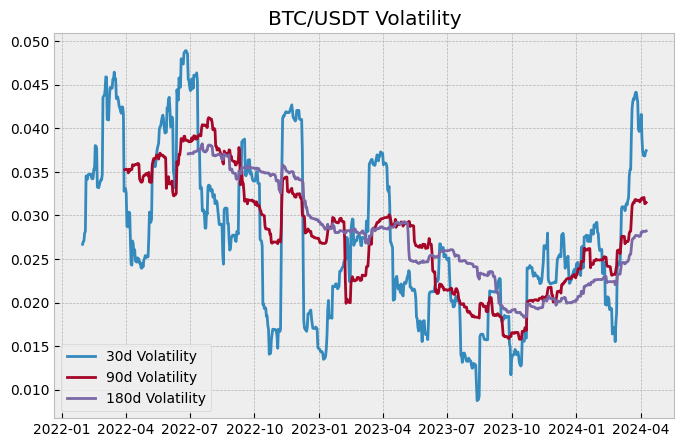

In [4]:
# 设置参数
ticker = "BTC/USDT"
start_date = dt.datetime(2022, 1, 1)
end_date = dt.datetime(2024, 4, 30)
price_volatility = False  # True if you want to calculate price volatility, False if you want return volatility

# 选择数据
ohlcv_ticker = ohlcv.query("symbol == @ticker").loc[start_date:end_date].copy()
ohlcv_ticker["daily_return"] = ohlcv_ticker["close"].pct_change().fillna(0)
series = ohlcv_ticker["close"] if price_volatility else ohlcv_ticker["daily_return"]

# 计算不同滚动窗口的波动率
vol_30d = series.rolling(window=30).std()
vol_90d = series.rolling(window=90).std()
vol_180d = series.rolling(window=180).std()

# 数据可视化
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(vol_30d, label="30d Volatility")
ax.plot(vol_90d, label="90d Volatility")
ax.plot(vol_180d, label="180d Volatility")
ax.set_title(f"{ticker} Volatility")
_ = ax.legend()

应用GARCH模型预测波动率

In [11]:
import warnings
from arch import arch_model

warnings.filterwarnings("ignore")

In [20]:
# 参数
ticker = "BTC/USDT"
start_date = dt.datetime(2022, 1, 1)
end_date = dt.datetime(2024, 4, 30)
train_window = 500

# 计算日收益率
ohlcv_ticker = ohlcv.query("symbol == @ticker").loc[start_date:end_date].copy()
daily_return = ohlcv_ticker["close"].pct_change().dropna()


def forecast_vol_garch(y: pd.Series, p: int = 1, q: int = 1, dist: str = "t") -> float:
    """创建GARCH模型并生成向前一期预测的条件方差"""
    model = arch_model(
        y=y,  # 模型输入
        mean="Constant",  # 均值模型部分，zero - 零均值，Constant - 常数均值
        vol="GARCH",  # 波动性模型，GARCH - 广义自回归条件异方差，ARCH - 自回归条件异方差
        p=p,  # 自回归模型的滞后阶数
        q=q,  # 移动平均项的滞后阶数
        dist=dist,  # 模型残差的分布假设，t - 学生t分布，normal - 正态分布
    )
    result = model.fit(
        disp="off", show_warning=False
    )  # disp="off", 不显示拟合过程的输出
    return result.forecast(horizon=1).variance.iloc[0, 0]


# 用GARCH模型预测波动率
forecast_variances = daily_return.rolling(window=train_window).apply(forecast_vol_garch)

# 计算标准差，作为波动率的衡量指标
# GARCH模型的预测结果是条件方差，需要开方得到标准差
# 还需要将预测结果向后移动一期，因为预测的是未来一期的条件方差
forecast_vol = np.sqrt(forecast_variances.shift(1))

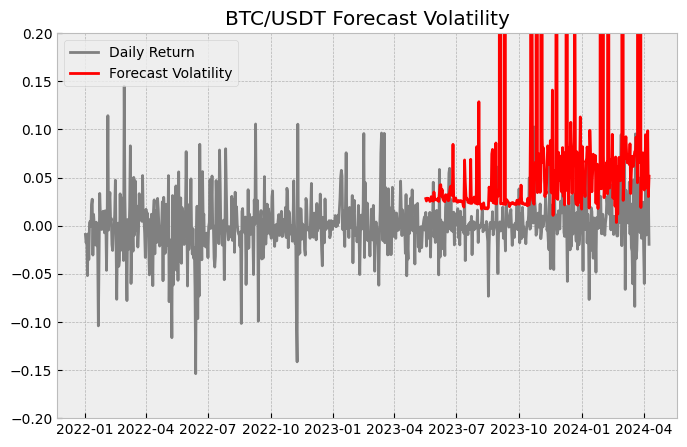

In [27]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(daily_return, label="Daily Return", color="grey")
ax.plot(forecast_vol, label="Forecast Volatility", color="red")
ax.set_ylim(-0.2, 0.2)
ax.set_title(f"{ticker} Forecast Volatility")
_ = ax.legend()